<div style="border-top: 3px solid #0a6d91; padding: 15px; display: flex; align-items: center; justify-content: space-between;">

  <!-- Left text -->
  <div style="flex: 1; padding-right: 20px;">
    <h1 style= display: inline-block; padding: 5px 10px; border-radius: 3px;">
      Mutual Information Dynamics <br> in VAEs
    </h1>
    <h3>Information theory and inference</h3>
  </div>

  <!-- Right images -->
  <div style="flex: 0 0 auto; display: flex; align-items: center; gap: 20px;">
    <img src="https://th.bing.com/th/id/R.f158dd00f7e0e326ff081cf1acb39901?rik=tfJW%2frH3keCJ%2fg&riu=http%3a%2f%2fboostlab.dfa.unipd.it%2fimg%2flogo_pod.png&ehk=Th6GDiUuQTgD%2faBhIK7JUi15%2bG%2f35LzMJV9PFEPd9rg%3d&risl=&pid=ImgRaw&r=0" alt="PoD" width="250"/>
    <img src="https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova-1024x463.png" alt="UNIPD" width = "350" />
  </div>

</div>
<div style="border-bottom: 1px solid #0a6d91">
  <p><strong>Authors</strong></p>
  <table style="border-collapse: collapse; display: inline-table;">
    <tr>
      <td style="padding: 1px;">Boscolo Marco</td>
      <td style="padding: 1px;">2157559</td>
    </tr>
    <tr>
      <td style="padding: 1px;">La Rovere Francesco</td>
      <td style="padding: 1px;">2164968</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Montagner Nicolò</td>
      <td style="padding: 1px;">2165809</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Sabatini Raffaele</td>
      <td style="padding: 1px;">2165739</td>
    </tr>
  </table>
</div>

# 0. Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

import torch
from torch import nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# Our VAE class
from VariationalModel import *

# 1. Set up

## Tracking Layers

In [3]:
activations = {}

def get_activation(name):
    """Create a hook that saves the layer output."""
    def hook(module, inputs, output):
        activations[name] = output.detach()
    return hook


def setup_hooks(model):
    """Register forward hooks on encoder, decoder, latent, and output layers."""
    activations.clear()

    # Encoder layers
    for i, layer in enumerate(model.Encoder):
        layer.register_forward_hook(get_activation(f"encoder_layer_{i+1}"))

    # Decoder layers
    for i, layer in enumerate(model.Decoder):
        layer.register_forward_hook(get_activation(f"decoder_layer_{i+1}"))

    # Latent space (Identity module)
    model.LatentSpace.register_forward_hook(get_activation("latent_space"))

    # Output space (Identity module)
    model.OutputSpace.register_forward_hook(get_activation("output_space"))

## Mutual Info (KDE method)

In [4]:
def kde_entropy(data, sigma=0.1):

    # If data are on gpu we need to move to cpu
    if isinstance(data, torch.Tensor): data = data.detach().cpu().numpy()

    N, d = data.shape

    data_sq = np.sum(data**2, axis=1, keepdims=True)
    dists_sq = data_sq + data_sq.T - 2 * np.dot(data, data.T)

    kernel = np.exp(-dists_sq / (2 * sigma**2))
    density = np.mean(kernel, axis=1)

    return -np.mean(np.log(density + 1e-10))


def MutualInfo(layer_data, target_data, sigma=0.1):
    h_layer = kde_entropy(layer_data, sigma)
    h_target = kde_entropy(target_data, sigma)

    joint = np.concatenate([layer_data, target_data], axis=1)
    h_joint = kde_entropy(joint, sigma)

    return h_layer + h_target - h_joint

In [5]:
def VAE_info(model, dataset, device, num_samples):
    model.eval()
    model.to(device)

    loader = torch.utils.data.DataLoader(dataset, batch_size=num_samples, shuffle=True)
    inputs, _ = next(iter(loader))
    inputs = inputs.to(device)

    # One forward pass to populate activations
    with torch.no_grad():
        outputs, z = model(inputs)

    X_data = inputs.view(inputs.size(0), -1).detach().cpu().numpy()
    Z_data = activations["latent_space"].detach().cpu().numpy()
    Y_data = activations["output_space"].detach().cpu().numpy()

    mi = {"encoder": [], "decoder": []}

    # Encoder MI
    for i in range(1, len(model.Encoder) + 1):
        act = activations[f"encoder_layer_{i}"].detach().cpu().numpy()
        mi["encoder"].append((
            MutualInfo(act, X_data),
            MutualInfo(act, Z_data)
        ))

    # Decoder MI
    for i in range(1, len(model.Decoder) + 1):
        act = activations[f"decoder_layer_{i}"].detach().cpu().numpy()
        mi["decoder"].append((
            MutualInfo(act, Z_data),
            MutualInfo(act, Y_data)
        ))

    return mi

## Dataset

In [6]:
dataDirectory = 'Dataset'

trainDataset = torchvision.datasets.MNIST(dataDirectory, train=True, download=True)
testDataset  = torchvision.datasets.MNIST(dataDirectory, train=False, download=True)

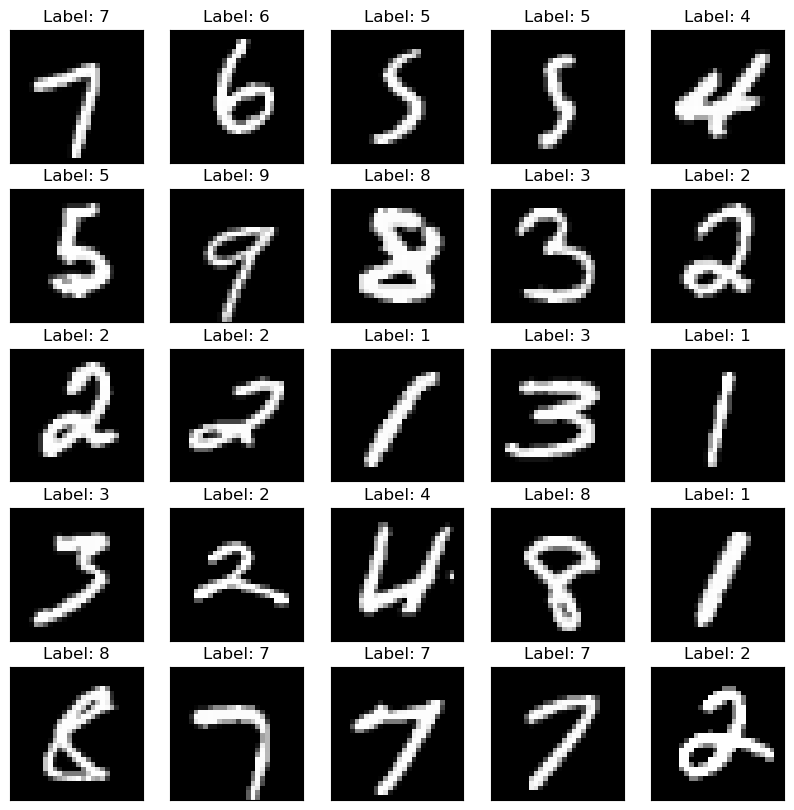

In [7]:
fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for ax in axs.flatten():
   img, label = random.choice(trainDataset)
   ax.imshow(np.array(img), cmap = 'gist_gray')
   ax.set_title(f'Label: {label}')
   ax.set_xticks([])
   ax.set_yticks([])

In [8]:
#Transforms in pytorch tensors
trainTransform = transforms.Compose([transforms.ToTensor(),])
testTransform = transforms.Compose([transforms.ToTensor(),])

trainDataset.transform = trainTransform
testDataset.transform = testTransform

In [9]:
#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=500, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=500, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([500, 1, 28, 28])
	 Labels: torch.Size([500])
TEST BATCH SHAPE
	 Data: torch.Size([500, 1, 28, 28])
	 Labels: torch.Size([500])


# 2. VAE model

## Set up model

In [10]:
model = VariationalAutoEncoder(latentDim = 50, hiddenDim=[200, 150, 100], Variational = False)

In [11]:
loss_fn = torch.nn.MSELoss()

lr = 5e-4
parameToOptimize = [
   {'params': model.parameters()}
]

optim = torch.optim.Adam(parameToOptimize, lr = lr)
if torch.backends.mps.is_available():
   device = torch.device("mps")
elif torch.cuda.is_available():
   device = torch.device("cuda")
else:
   device = torch.device("cpu")

print(f'Selected device: {device}')

model.to(device)

Selected device: cuda


VariationalAutoEncoder(
  (Encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=150, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=150, out_features=100, bias=True)
      (1): ReLU()
    )
  )
  (LatentSpace): Linear(in_features=100, out_features=50, bias=True)
  (Decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=50, out_features=100, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=150, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=150, out_features=200, bias=True)
      (1): ReLU()
    )
  )
  (OutputLayer): Linear(in_features=200, out_features=784, bias=True)
  (OutputSpace): Identity()
)

## Training Model

In [12]:
train_loss_history = []
val_loss_history = []

# for mutual info
history_encoder = []
history_decoder = []

In [13]:
def Training(model, num_epochs=10, showImage=False):
    setup_hooks(model)

    for epoch in range(num_epochs):
        model.train()
        losses = []

        for images, _ in tqdm(trainDataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)

            outputs, z = model(images)
            targets = images.view(images.size(0), -1)

            loss = loss_fn(outputs, targets)

            optim.zero_grad()
            loss.backward()
            optim.step()

            losses.append(loss.detach().cpu().numpy())

        avg_train_loss = np.mean(losses)
        train_loss_history.append(avg_train_loss)

        # -------- Validation loss --------
        model.eval()
        val_losses = []

        with torch.no_grad():
            for images, _ in testDataloader:
                images = images.to(device)

                outputs, z = model(images)
                targets = images.view(images.size(0), -1)

                loss = loss_fn(outputs, targets)
                val_losses.append(loss.cpu().numpy())

        avg_val_loss = np.mean(val_losses)
        val_loss_history.append(avg_val_loss)

        # -------- Mutual Information --------
        res = VAE_info(model, trainDataset, device, num_samples=4000)
        history_encoder.append(res['encoder'])
        history_decoder.append(res['decoder'])

        print(
            f"TRAIN — Epoch {epoch+1}/{num_epochs} — "
            f"train loss: {avg_train_loss:.4f} — "
            f"val loss: {avg_val_loss:.4f}"
        )

        if showImage:
            img = testDataset[0][0].unsqueeze(0).to(device)

            with torch.no_grad():
                recon = model(img)[0]

            fig, axs = plt.subplots(1, 2, figsize=(12, 6))

            axs[0].imshow(img.cpu().squeeze(), cmap='gist_gray')
            axs[0].set_title("Original image")

            axs[1].imshow(recon.cpu().squeeze().reshape(28, 28), cmap='gist_gray')
            axs[1].set_title(f"Reconstruction (epoch {epoch+1})")

            plt.tight_layout()
            plt.show()
            plt.close()

    return np.mean(losses)

In [14]:
epoch = 10
final_loss = Training(model, num_epochs=epoch, showImage=False)

Epoch 1/10: 100%|████████████████████████████████████████████| 120/120 [00:04<00:00, 29.98it/s]


TRAIN — Epoch 1/10 — train loss: 0.1004 — val loss: 0.0673


Epoch 2/10: 100%|████████████████████████████████████████████| 120/120 [00:01<00:00, 84.07it/s]


TRAIN — Epoch 2/10 — train loss: 0.0647 — val loss: 0.0612


Epoch 3/10: 100%|████████████████████████████████████████████| 120/120 [00:01<00:00, 81.15it/s]


TRAIN — Epoch 3/10 — train loss: 0.0572 — val loss: 0.0534


Epoch 4/10: 100%|████████████████████████████████████████████| 120/120 [00:01<00:00, 83.77it/s]


TRAIN — Epoch 4/10 — train loss: 0.0503 — val loss: 0.0467


Epoch 5/10: 100%|████████████████████████████████████████████| 120/120 [00:01<00:00, 84.40it/s]


TRAIN — Epoch 5/10 — train loss: 0.0436 — val loss: 0.0410


Epoch 6/10: 100%|████████████████████████████████████████████| 120/120 [00:01<00:00, 85.23it/s]


TRAIN — Epoch 6/10 — train loss: 0.0387 — val loss: 0.0360


Epoch 7/10: 100%|████████████████████████████████████████████| 120/120 [00:01<00:00, 82.28it/s]


TRAIN — Epoch 7/10 — train loss: 0.0345 — val loss: 0.0326


Epoch 8/10: 100%|████████████████████████████████████████████| 120/120 [00:01<00:00, 75.99it/s]


TRAIN — Epoch 8/10 — train loss: 0.0320 — val loss: 0.0312


Epoch 9/10: 100%|████████████████████████████████████████████| 120/120 [00:01<00:00, 83.05it/s]


TRAIN — Epoch 9/10 — train loss: 0.0303 — val loss: 0.0294


Epoch 10/10: 100%|███████████████████████████████████████████| 120/120 [00:01<00:00, 87.18it/s]


TRAIN — Epoch 10/10 — train loss: 0.0291 — val loss: 0.0282


# 2.bis Debug

In [ ]:
# activations

In [ ]:
# a = activations['decoder_layer_1'].detach().cpu().numpy()[0]
# print(len(a),"\n",a)

In [ ]:
# history_encoder

In [ ]:
# history_decoder

# 3. Results

## VAE outputs

In [28]:
def ShowSomeImages(model, testDataset, device):

    model.eval()
    fig, axs = plt.subplots(5, 2, figsize=(6, 12))

    for i in range(5):
        img, _ = random.choice(testDataset)

        x = img.unsqueeze(0).to(device)

        with torch.no_grad():
            recon, _ = model(x)

        original = img.cpu().squeeze().numpy()
        reconstructed = recon.cpu().squeeze().numpy().reshape(28, 28)

        axs[i, 0].imshow(original, cmap="gist_gray")
        axs[i, 0].set_title("Original")
        axs[i, 0].set_xticks([])
        axs[i, 0].set_yticks([])

        axs[i, 1].imshow(reconstructed, cmap="gist_gray")
        axs[i, 1].set_title("Reconstruction")
        axs[i, 1].set_xticks([])
        axs[i, 1].set_yticks([])

    plt.tight_layout()
    plt.show()

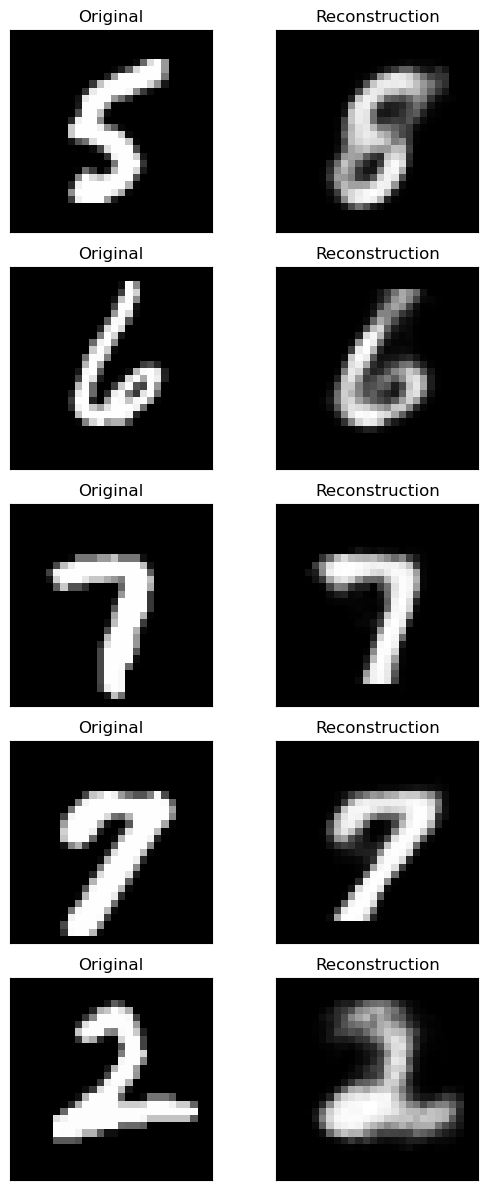

In [29]:
ShowSomeImages(model, testDataset, device)

## VAE loss

In [16]:
def PlotLoss(train_loss_history, val_loss_history):
    epochs = range(1, len(train_loss_history) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss_history, color='blue', linewidth=2, label='Training loss')
    plt.plot(epochs, val_loss_history, color='red', linewidth=2, label='Validation loss')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

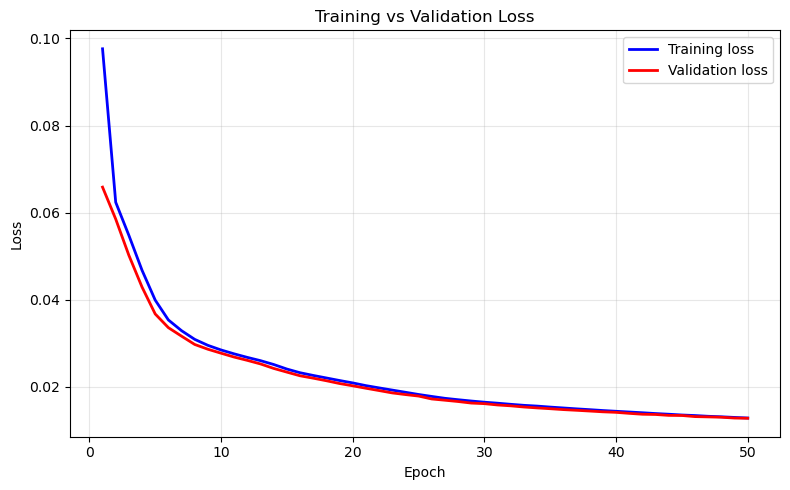

In [23]:
PlotLoss(train_loss_history, val_loss_history)

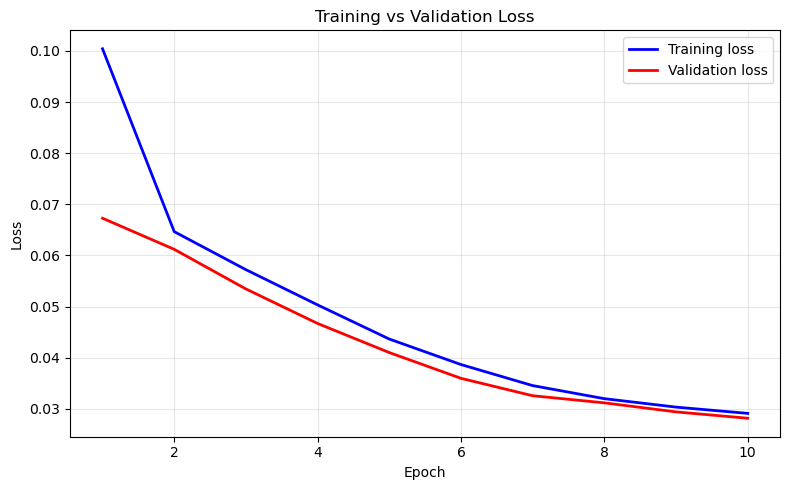

In [17]:
PlotLoss(train_loss_history, val_loss_history)

## Mutual Info

In [24]:
def PlotInfoPlane(mi_history_encoder, mi_history_decoder, title_suffix="", start_epoch=1, end_epoch=-1):

    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[6, 6, 0.2], wspace=0.3)

    ax_enc = fig.add_subplot(gs[0, 0])
    ax_dec = fig.add_subplot(gs[0, 1])
    ax_cb  = fig.add_subplot(gs[0, 2])

    total_epochs = len(mi_history_encoder)
    if end_epoch == -1 or end_epoch >= total_epochs:
        end_epoch = total_epochs - 1

    epoch_range = range(start_epoch, end_epoch + 1)
    epochs = len(epoch_range)

    cmap = plt.get_cmap('viridis')
    colors = [cmap(i / max(1, epochs - 1)) for i in range(epochs)]

    # Two different marker sets
    encoder_markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']
    decoder_markers = ['>', '*', 'p', 'h', 'H', '>', 'd', 'D', '8', 'o']

    n_layers = len(mi_history_encoder[0])

    # ---------------- ENCODER ----------------
    ax = ax_enc

    for ep_idx, ep in enumerate(epoch_range):
        x = [mi_history_encoder[ep][l][0] for l in range(n_layers)]
        y = [mi_history_encoder[ep][l][1] for l in range(n_layers)]

        ax.plot(x, y, linestyle='-', color=colors[ep_idx],
                alpha=0.6, linewidth=2)

        for l in range(n_layers):
            marker = encoder_markers[l % len(encoder_markers)]
            ax.scatter(x[l], y[l],
                       facecolors=[colors[ep_idx]],
                       edgecolors='black',
                       s=60, marker=marker,
                       linewidths=0.6, zorder=3)

    ax.set_xlabel("I(Layer; Input)", fontsize=14)
    ax.set_ylabel("I(Layer; Latent Z)", fontsize=14)
    ax.set_title(f"Encoder Information Plane {title_suffix}", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)

    # Encoder legend
    enc_handles = []
    enc_labels = []
    for l in range(n_layers):
        mk = encoder_markers[l % len(encoder_markers)]
        handle = Line2D([0], [0], marker=mk, color='black',
                        markerfacecolor='black',
                        markeredgecolor='black',
                        markersize=10, linestyle='None')
        enc_handles.append(handle)
        enc_labels.append(f'Layer {l+1}')

    ax_enc.legend(enc_handles, enc_labels, framealpha=0.9, fontsize=12, title_fontsize=13)

    # ---------------- DECODER ----------------
    ax = ax_dec

    for ep_idx, ep in enumerate(epoch_range):
        x = [mi_history_decoder[ep][l][0] for l in range(n_layers)]
        y = [mi_history_decoder[ep][l][1] for l in range(n_layers)]

        ax.plot(x, y, linestyle='-', color=colors[ep_idx],
                alpha=0.6, linewidth=2)

        for l in range(n_layers):
            marker = decoder_markers[l % len(decoder_markers)]
            ax.scatter(x[l], y[l],
                       facecolors=[colors[ep_idx]],
                       edgecolors='black',
                       s=60, marker=marker,
                       linewidths=0.6, zorder=3)

    ax.set_xlabel("I(Layer; Latent Z)", fontsize=14)
    ax.set_ylabel("I(Layer; Output)", fontsize=14)
    ax.set_title(f"Decoder Information Plane {title_suffix}", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)

    # Decoder legend
    dec_handles = []
    dec_labels = []
    for l in range(n_layers):
        mk = decoder_markers[l % len(decoder_markers)]
        handle = Line2D([0], [0], marker=mk, color='black',
                        markerfacecolor='black',
                        markeredgecolor='black',
                        markersize=10, linestyle='None')
        dec_handles.append(handle)
        dec_labels.append(f'Layer {l+1}')

    ax_dec.legend(dec_handles, dec_labels, framealpha=0.9, fontsize=12, title_fontsize=13)

    # ---------------- COLORBAR ----------------
    norm = Normalize(vmin=start_epoch, vmax=end_epoch)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=ax_cb, orientation='vertical')
    cbar.set_ticks(list(epoch_range))
    cbar.set_ticklabels(list(epoch_range))
    cbar.set_label("Epoch", fontsize=14)

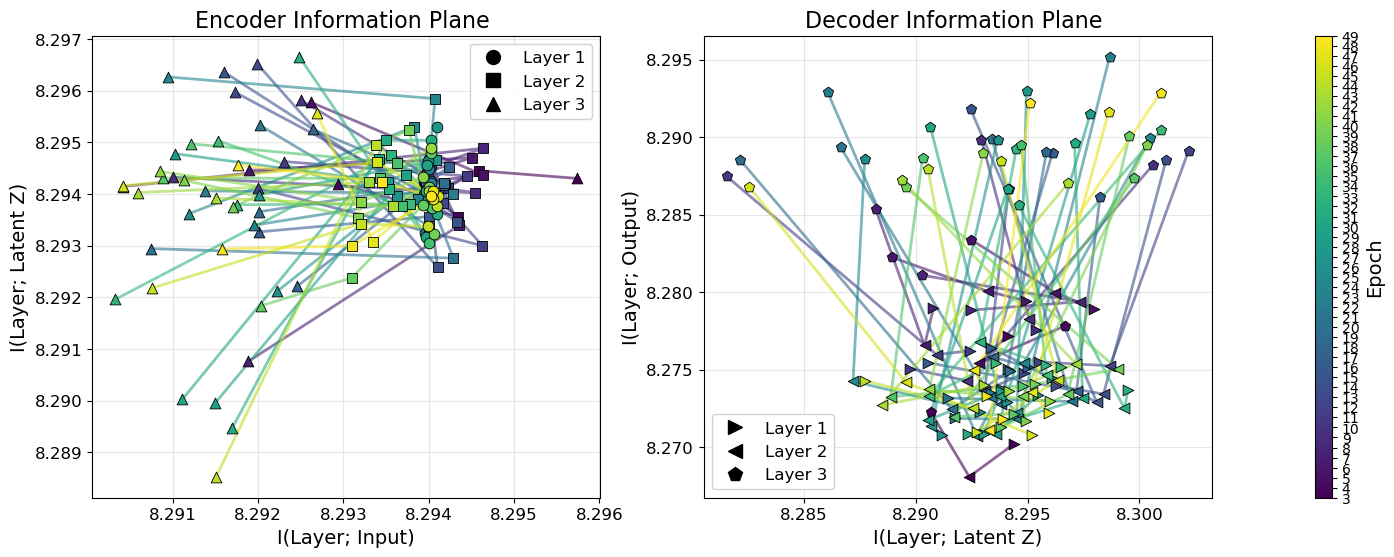

In [27]:
PlotInfoPlane(history_encoder, history_decoder, start_epoch=3, end_epoch=-1)

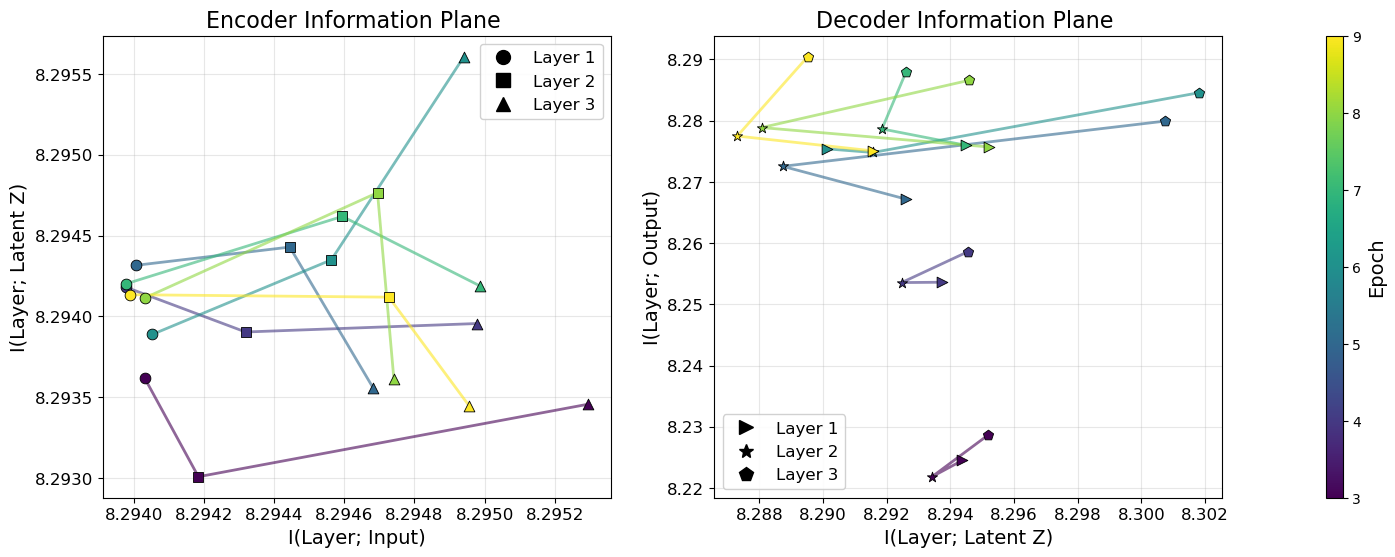

In [27]:
PlotInfoPlane(history_encoder, history_decoder, start_epoch=3, end_epoch=-1)